# Decision Tree Model

- Written by Yeon Soo Choi, Research Unit, World Customs Organization
- Updated on 2020.6.26.

## Decision Tree

Lets start with the most intuitive and basic machine learning model, “Decision Tree”. A decision tree model seems like an upside down tree. Each node presents a closed question to be answered with “Yes” or “No”. You start from a question at the root (top) node. If you answer “Yes”, you move to the left, otherwise to the right. By answering all the questions on your routes, you will reach one of terminal (bottom or leaf) nodes, where you will find what your tree predicts.

## Outline
[**1. Data loading and preprocessing**](#id1)  
[**2. Undersampling in train data**](#id2)  
[**3. Construct a Decision Tree model**](#id3)    
[**4. Train the model**](#id4)    
[**5. Test the model (Predict frauds in test-data with the Decision Tree model)**](#id5)  
[**6. Evaluate model performance**](#id6)

## 1. Data loading and preprocessing<a id='id1'></a>  

In [1]:
# Set environment (load libraries/packages)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
pd.set_option('display.max_columns', 100)

In [2]:
# Load data
df_raw = pd.read_csv('./synthetic_data2.csv')

In [3]:
# Select columns to use
columns_to_use = ['year', 'month', 'day', 'OFFICE', 'IMPORTER.TIN',
       'TARIFF.CODE', 'ORIGIN.CODE', 'CIF_USD_EQUIVALENT', 'QUANTITY',
       'GROSS.WEIGHT','TOTAL.TAXES.USD', 'illicit']
df_raw = df_raw[columns_to_use]

In [4]:
# Make a copy not to change the origincal data (to be used later)
df = df_raw.copy()

In [5]:
# Create additional numeric and categorical variables

def preprocess(df:pd.DataFrame, 
               args:list):
    """
    dtype df: dataframe
    dtype *args: strings (attribute names that want to be combined)
    """
    # create additional numeric variables
    df.loc[:, 'Unitprice'] = df.loc[:,'CIF_USD_EQUIVALENT']/df.loc[:,'QUANTITY']
    df.loc[:, 'WUnitprice'] = df.loc[:,'CIF_USD_EQUIVALENT']/df.loc[:,'GROSS.WEIGHT']
    df.loc[:, 'TaxRatio'] = df.loc[:,'TOTAL.TAXES.USD'] / df.loc[:,'CIF_USD_EQUIVALENT']
    df.loc[:, 'TaxUnitquantity'] = df.loc[:,'TOTAL.TAXES.USD'] / df.loc[:,'QUANTITY']
    
    # Create HS sub-classes
    df.loc[:, 'HS6'] = df['TARIFF.CODE'].apply(lambda x: int(x) // 10000).astype(str) #HS10digit
    #df.loc[:, 'HS4'] = df['HS6'].apply(lambda x: int(x) // 100).astype(str)
    #df.loc[:, 'HS2'] = df['HS4'].apply(lambda x: int(x) // 100).astype(str)
    
    # Merge attributes
    
    df.loc[:,args] = df.loc[:,args].astype(str)
    
    # Generate all the pairs available from the selected categorical variables
    import itertools
    combinations = list(itertools.combinations(args, 2))
    
    # Run a loop for merging attributes 
    for (cat1, cat2) in combinations:
        ColName = cat1 + '&' + cat2
        df.loc[:,ColName] = df.loc[:,cat1]+'&'+df.loc[:,cat2]
    
    return df

In [6]:
# Identify high risky entities (importer, declarants, HScodes, Offices, origin countries, etc.)

def risk_profiling(df:pd.DataFrame, 
                   feature:str, 
                   topk_ratio:float):
    
    N_top10pct = int(df[feature].nunique()*topk_ratio)+1
    RiskH_list = list(df.groupby(feature)['illicit'].sum().sort_values(ascending=True).head(N_top10pct).index)
    
    return RiskH_list

In [7]:
def risk_tagging(df:pd.DataFrame, 
                 feature:str, 
                 RiskH_list:list):
    
    df.loc[:,'RiskH.'+feature] = np.where(df.loc[:,feature].isin(RiskH_list),1,0)
    
    return df

In [8]:
# split train/valid/test set

train = df[df['year']==2013]
test = df[df['year']==2014]
print("Now, train-data has {} entries and {} features".format(*train.shape))
print("Now, test-data has {} entries and {} features".format(*test.shape))

Now, train-data has 113223 entries and 12 features
Now, test-data has 86777 entries and 12 features


In [9]:
# Preprocess train and test
train = preprocess(train, ['OFFICE', 'IMPORTER.TIN','TARIFF.CODE', 'ORIGIN.CODE'])
test = preprocess(test, ['OFFICE', 'IMPORTER.TIN','TARIFF.CODE', 'ORIGIN.CODE'])

/newsdd/bacuda_big/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/newsdd/bacuda_big/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [10]:
profile_candidates = ['OFFICE', 'IMPORTER.TIN','TARIFF.CODE', 'HS6', #'HS4', 'HS2', 
                      'ORIGIN.CODE']\
+[col for col in train.columns if '&' in col]

In [11]:
# Risk profiling
for feature in profile_candidates:
    # Identify high risky entities 
    RiskH_list = risk_profiling(train, feature, 0.1)
    # Tag 'RiskH'
    train = risk_tagging(train, feature, RiskH_list)
    # Attention: Tags for test data are built from train data (not from test data)
    test = risk_tagging(test, feature, RiskH_list)

## 2. Undersampling (downsampling) in train-data <a id='id2'></a>  
If we train our machine with 9000 non-frauds and 1000 frauds, predictions of our machine are likely to be biased toward non-fraud. Therefore, we need balanced number of frauds and non-frauds for better training. We can use only 1000 non-frauds (undersampling), or we can generate 8000 artificial frauds (over-sampling). This notebook will use the former.  

In [12]:
from sklearn.utils import resample

# Downsampling 
train_majority = train[train.illicit==0] # create a subset of non-frauds
train_minority = train[train.illicit==1] # create a subset of frauds
train_majority_downsampled = resample(train_majority, # population group
                                      replace=False,  # no duplicated selection is allowed
                                      n_samples=len(train_minority), # number of selection 
                                      random_state=123) # reproducibility
train_downsampled = pd.concat([train_majority_downsampled, train_minority])

# Use Downsampled data
train = train_downsampled
print("Now, train-dataset(undersampled) has {} entries and {} features".format(*train.shape))
print("Now, test-dataset has {} entries and {} features".format(*test.shape))

Now, train-dataset(undersampled) has 15594 entries and 34 features
Now, test-dataset has 86777 entries and 34 features


We will drop categorical variables from the data. 

In [13]:
# Before removing 'fraud' variables, Create Fraud labels
train_fraud = train.illicit
test_fraud = test.illicit

# Select columns to use in a classifier
column_to_use = ['CIF_USD_EQUIVALENT', 'QUANTITY','GROSS.WEIGHT','TOTAL.TAXES.USD', #'TARIFF.CODE', 
                 'Unitprice', 'WUnitprice', 'TaxRatio', 'TaxUnitquantity'] + [col for col in train.columns if 'RiskH' in col] 
train = train[column_to_use]
test = test[column_to_use]

print("Now, train-dataset(undersampled) has {} entries and {} features".format(*train.shape))
print("Now, test-dataset has {} entries and {} features".format(*test.shape))

Now, train-dataset(undersampled) has 15594 entries and 19 features
Now, test-dataset has 86777 entries and 19 features


## 3. Construct a Decision tree model <a id='id3'></a> 

In [14]:
from sklearn.tree import DecisionTreeClassifier
# Instantiate a Decision Tree model
DT_cl = DecisionTreeClassifier(max_depth=9) # To reproduce

## 4. Train the model <a id='id4'></a>

In [15]:
# Fit the classifier to the training set
DT_cl.fit(train,train_fraud)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

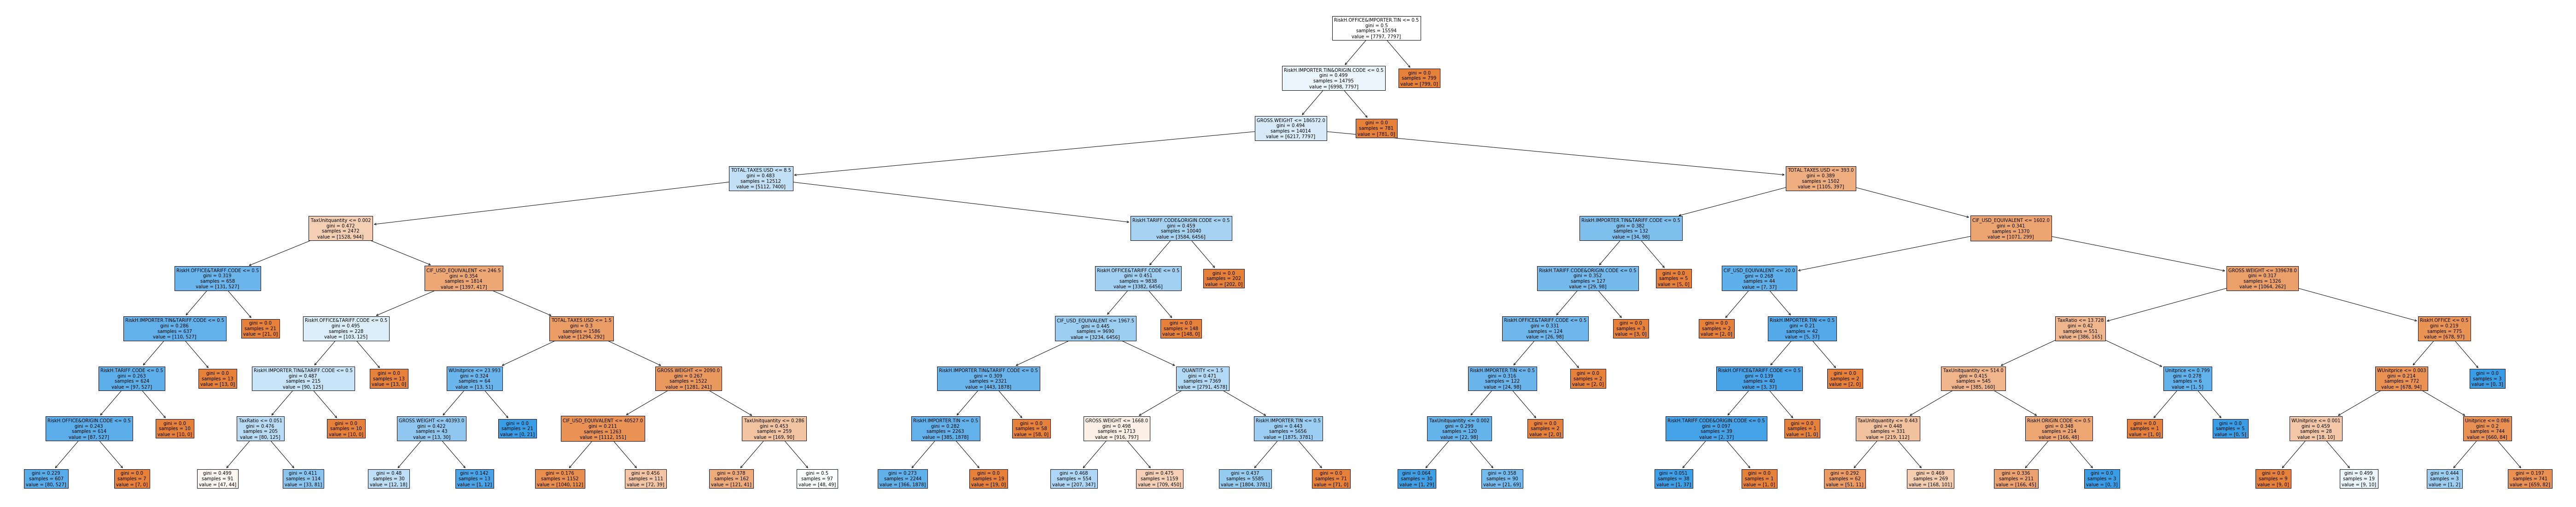

In [16]:
# Plot tree
from sklearn import tree
fig, ax = plt.subplots(figsize=(100, 20))
tree.plot_tree(DT_cl,
               feature_names = train.columns,
               filled=True, 
               fontsize=10)
plt.show()

## 5. Predict frauds in test-data with the Decision Tree model <a id='id5'></a>

In [17]:
# Predict the labels of the test set: preds
predicted_fraud_cl = DT_cl.predict_proba(test)[:,1]
predicted_fraud_cl

array([0.67699194, 0.67699194, 0.8368984 , ..., 0.        , 0.09722222,
       0.67699194])

## 6. Evaluate model performance  <a id='id6'></a>

### Evaluate the prediction of XGboost model (General)

ROC curve is a plot of "True Positive rate (TP)" on y-axis against "False Positive rate (FP)" on x-axis, where;
* "True positive rate" (or 'sensitivity' or 'recall') is the share of correctly predicted frauds in the total frauds.
* "False positive rate" (or 'false alarm' or '1-specificity') is the share of non-frauds predicted as frauds in the total non-frauds.  

ROC curve with the higher TP and the lower FP represents the better performance.  
AUC is the area under the ROC curve. The higer value of AUC represents the higher performance of prediction.  

References for ROC curve and AUC:
* https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

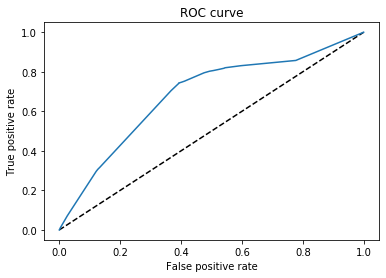

auc:  0.6816550285741388


In [18]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, _ = roc_curve(test_fraud, predicted_fraud_cl)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()
print('auc: ', auc(fpr, tpr))

### Evaluate the prediction of XGboost (for Customs)
ROC curve and AUC may seem too technical for Customs. We will convert the ROC curve (a plot with "TP" and "FP") into the plot with "Inspection rate" and "Number of seizures" or/and the plot with "Inspection rate" and "Targeting accuracy".

In [19]:
# Evaluate by the performance of (simulated) inpsection

def inspection_performance(predicted_fraud, test_fraud):
    
    # Set default values before a loop
    
    Inspect_Rate = []
    Precision=[]
    Recall=[]
    
    # Create a loop for making confusion matrix at each inspection rate

    for i in range(0,101,1):
        
        # Find the ith value in ascending order.
        threshold = np.percentile(predicted_fraud, i)
        # Precision = number of frauds / number of inspection
        precision = np.mean(test_fraud[predicted_fraud > threshold])
        # Recall = number of inspected frauds / number of frauds
        recall = sum(test_fraud[predicted_fraud > threshold])/sum(test_fraud)
        # Save values
        Inspect_Rate.append(100-i)
        Precision.append(precision)
        Recall.append(recall)
        
    
    compiled_conf_matrix = pd.DataFrame({
        
        'Inspect_Rate':Inspect_Rate,
        'Precision':Precision,
        'Recall':Recall
    })

    return compiled_conf_matrix

In [20]:
basic_performance = inspection_performance(predicted_fraud_cl, test_fraud)
basic_performance.iloc[[100-1, 100-2, 100-5, 100-10],:]

Inspect_Rate  Precision    Recall
99             1   0.205607  0.010041
98             2   0.205607  0.010041
95             5   0.181748  0.071200
90            10   0.181748  0.071200

In [21]:
# Export the performance table
basic_performance.to_csv('perf_DT.csv', index=False)

### Visualize performance

In [22]:
data = pd.melt(basic_performance, 
               id_vars = ['Inspect_Rate'],
               value_vars = ['Recall','Precision'])

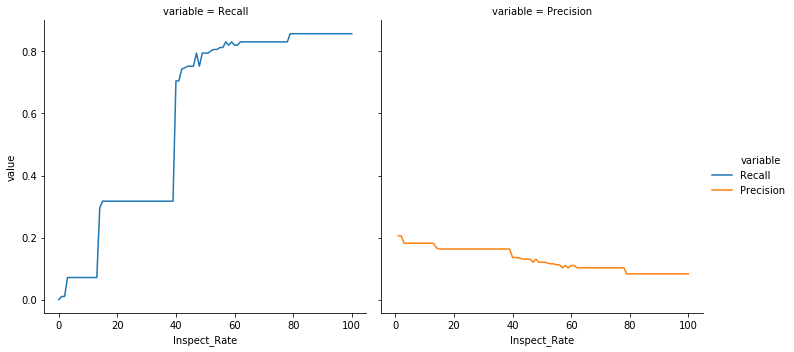

In [23]:
sns.relplot(data=data,
            kind='line',
            x="Inspect_Rate", 
            y="value", 
            hue='variable',
            col="variable")

In [24]:
# Interactive visualization
fig = px.line(data, x="Inspect_Rate", y="value", color='variable',facet_col="variable")
fig.show()